#### Deducing the Concentration of PM2.5 based on AOD and weather, etc. with Machine Learning Models
# Performing Multivariate Linear Regression
Author: Weiye Chen (weiyechen@zju.edu.cn) <br>
Collaborating with Keran Sun, Qingjie Yang, Anzhou Li.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from scipy import stats
import pandas as pd
import warnings; warnings.simplefilter('ignore') ## Just for nice display

In [2]:
# Render matplotlib graph as SVG
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Load table data

In [3]:
def loadSample(date, hour):       
    with open('./table/data-'+ str(date) + "-" + str(hour) + '.csv', newline='') as csvfile:
        x_aod = []
        x_at = []
        x_dem = []
        x_rh = []
        x_pr = []
        x_ndvi = []
        x_ws = []
        y = []
        ones = []
        table = csv.DictReader(csvfile, delimiter=',', quotechar='|')
        for row in table:
            ones.append(1.0)
            x_aod.append(float(row['AOD']))
            x_at.append(float(row['AirTemp']))
            x_dem.append(float(row['DEM']))
            x_rh.append(float(row['RH']))
            x_pr.append(float(row['SeaLevelPr']))
            x_ndvi.append(float(row['NDVI']))
            x_ws.append(float(row['WindSpeed']))
            y.append(float(row['pm2_5']))
        xt = [np.array(ones),
              x_ndvi, 
              x_dem, 
              x_aod, 
              x_at, 
              x_rh, 
              x_pr, 
              x_ws]
        xt_np = np.asarray(xt)
        x = np.transpose(xt_np)
        y_np = np.transpose(np.asarray([y]))
#         print(np.shape(y_np))
#         print(x)
#         print(xt_np)
#         print(y_np)
        return x, xt_np, y_np

### A MLR computation model

In [4]:
class MLR:     
    def __init__(self, x, y = None):
        
        self.init()
        if (y is None):
            self.x = np.array(matrix[:,0:-1])
            self.y = np.array(matrix[:,-1])
            shape = np.shape(matrix)
            self.k = shape[1] - 2
            self.n = shape[0]
        else:
            self.x = x
            self.y = y
            self.k = np.shape(x)[1] - 1
            self.n = np.shape(x)[0]
    
    def init(self):
        self.r2 = 0.
        self.t = []
        self.p_t = []
        self.f = 0.
        self.p_f = 0.
        self.ess = 0.
        self.rss = 0.
        self.tss = 0.
        self.r2_adj = 0.

        
    def OLS(self):
        x = self.x
        y = self.y
        x_t = np.transpose(x)
        xt_x_inv = np.matmul(x_t, x)
        xt_x_inv = np.linalg.inv(xt_x_inv)
        beta = np.matmul(xt_x_inv, x_t)
        beta = np.matmul(beta, y)
        self.beta = beta
        y_e = self.PredictionE(x)
        deviation1 = self.y - y_e
        deviation = deviation1 * deviation1
        self.rss = np.sum(deviation)
        mean = np.mean(y)
        self.tss = np.sum((y-mean) * (y-mean))
        self.ess = self.tss - self.rss
        self.f = (self.ess / self.k) / (self.rss / (self.n - self.k - 1))
        self.r2 = 1 - self.rss / self.tss
        self.r2_adj = 1 - (self.rss / (self.n - self.k - 1)) / (self.tss / (self.n - 1))
        self.p_f = 1 - stats.f.cdf(self.f, self.k, (self.n - self.k - 1))
        sigma2 = self.rss / (self.n - self.k - 1)
        beta_array = np.array(np.transpose(beta)[0])
        cii = []
        for i in range(0, self.k + 1):
            cii.append(xt_x_inv[i][i])
        cii_np = np.array(cii)
        self.t = beta_array / np.sqrt(cii_np * sigma2)
        self.p_t = 1 - stats.t.cdf(np.absolute(self.t), self.n - self.k - 1)
        
    def PredictionE(self, x):
        return np.matmul(x, self.beta)
    
    def PrintRegressionResult(self):
        genAttr = ['R Square', 'Adjusted R Square', 'f', 
                   'f_significance', 'Explained Sum of Squares', 
                   'Residual Sum of Squares', 'Total Sum of Squares']
        genVal = [self.r2, self.r2_adj, self.f, self.p_f, self.ess, self.rss, self.tss]
        varAttr = ['Constant', 'NDVI', 'DEM', 'AOD', 'Air Temperature', 
                   'Relative Humidity', 'Sea Level Pressure', 'Wind Speed']
        genDataset = list(zip(genAttr, genVal))
        varDataset = list(zip(varAttr, self.t, self.p_t))
        df1 = pd.DataFrame(data = genDataset, columns=['Index', 'Value'])
        df2 = pd.DataFrame(data = varDataset, columns=['Variable', 't', 'Significance'])
        return df1, df2

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Conduct Multivariate Linear Regression Analysis

In [6]:
def MLRAnalysis(date, hour):
    print(str(date) + "-" + str(hour))
    print("-------")
    x, xt, y = loadSample(date, hour)
    mlr = MLR(x, y)
    mlr.OLS()
    y_pred = mlr.PredictionE(x)
    print("MSE: " + str(mean_squared_error(y, y_pred)))
    print("R^2: " + str(r2_score(y, y_pred)))
    res = mlr.PrintRegressionResult()
    print(res[0])
    print()
    print(res[1])
    print()
    print()
    
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    fig.suptitle(u"Scatter Plot of Residual and Independent Variables: Testing for Heteroscedasticity" 
                 + str(date) + " " + str(hour+8) + ":00 UTC+8", fontweight="heavy")
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    variablesName = ["Constant(1)","NDVI", "DEM", "AOD", "Surface Temperature", "Relative Humidity", "Sea Level Pressure", " Wind Speed"]
    
    ax[0,0].set_title(str(date) + "-" + str(hour))
    ax[0,0].set_xlabel("Observed PM2.5")
    ax[0,0].set_ylabel("Residual")
    ax[0,0].scatter(y, y-y_pred)     
    x_new = np.linspace(y.min(), y.max(), 5)
    coefs = np.polynomial.polynomial.polyfit(y.flatten(), (y-y_pred).flatten(), 1)
    ffit = np.polynomial.polynomial.polyval(x_new, coefs)
    ax[0,0].plot(x_new, ffit, 'g')
    
    for i in range(1,8):
        xi = xt[i, :]
        ax[int(i/4), int(i%4)].set_xlabel(variablesName[i])
        ax[int(i/4), int(i%4)].set_ylabel("Residual")
        ax[int(i/4), int(i%4)].plot(xi, y-y_pred, 'b,')
        x_new = np.linspace(xi.min(), xi.max(), 5)
        coefs = np.polynomial.polynomial.polyfit(xi, (y-y_pred).flatten(), 1)
#         print(coefs)
        ffit = np.polynomial.polynomial.polyval(x_new, coefs)
        ax[int(i/4), int(i%4)].plot(x_new, ffit)
        
    fig.savefig("./SampleTablePlot/residual_plot_" + str(date) + "_" + str(hour) + ".png", dpi=100)
    fig.show()

14-1
-------
MSE: 90.76416321394377
R^2: 0.5645581412776206
                      Index         Value
0                  R Square  5.645581e-01
1         Adjusted R Square  5.539376e-01
2                         f  5.315723e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  3.471482e+04
5   Residual Sum of Squares  2.677543e+04
6      Total Sum of Squares  6.149025e+04

             Variable          t  Significance
0            Constant   6.829109  2.548672e-11
1                NDVI  -1.303788  9.667529e-02
2                 DEM   0.838029  2.013558e-01
3                 AOD   1.077880  1.409962e-01
4     Air Temperature  17.499991  0.000000e+00
5   Relative Humidity   9.415665  0.000000e+00
6  Sea Level Pressure  -6.870630  1.986045e-11
7          Wind Speed   0.812050  2.087180e-01




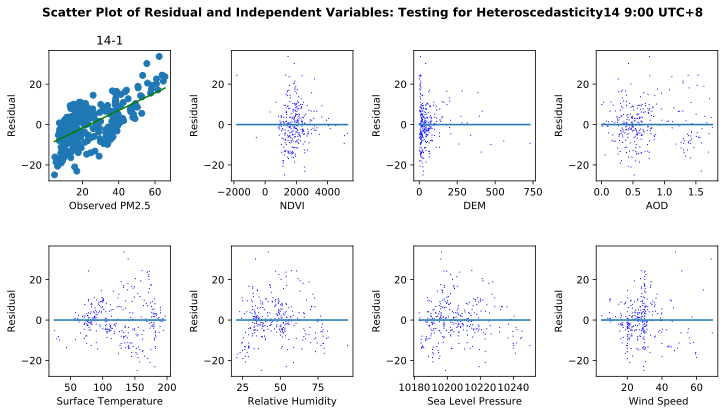

In [7]:
MLRAnalysis(14,1)

14-4
-------
MSE: 110.16707127146984
R^2: 0.34580735330956636
                      Index         Value
0                  R Square  3.458074e-01
1         Adjusted R Square  3.298514e-01
2                         f  2.167267e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  1.717918e+04
5   Residual Sum of Squares  3.249929e+04
6      Total Sum of Squares  4.967846e+04

             Variable          t  Significance
0            Constant   6.080178  1.909150e-09
1                NDVI  -2.566069  5.396764e-03
2                 DEM   0.813571  2.082826e-01
3                 AOD  -0.345769  3.648846e-01
4     Air Temperature  10.352408  0.000000e+00
5   Relative Humidity   9.556653  0.000000e+00
6  Sea Level Pressure  -6.082919  1.880458e-09
7          Wind Speed  -0.327938  3.715987e-01




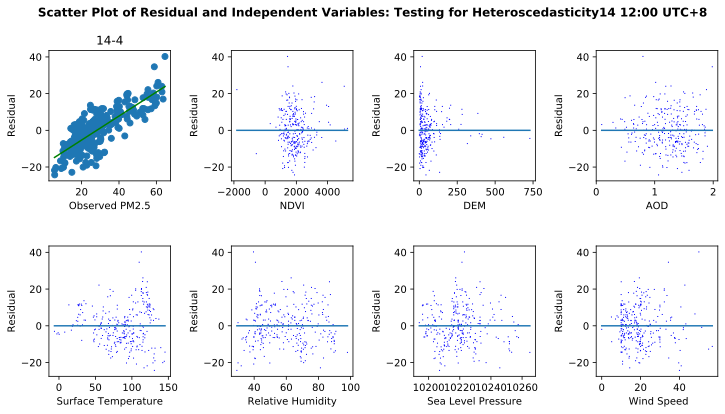

In [8]:
MLRAnalysis(14,4)

14-7
-------
MSE: 198.10239862700948
R^2: 0.2347277310067355
                      Index         Value
0                  R Square  2.347277e-01
1         Adjusted R Square  2.160626e-01
2                         f  1.257570e+01
3            f_significance  4.596323e-14
4  Explained Sum of Squares  1.792504e+04
5   Residual Sum of Squares  5.844021e+04
6      Total Sum of Squares  7.636525e+04

             Variable         t  Significance
0            Constant  3.444214  3.290788e-04
1                NDVI -2.876458  2.161596e-03
2                 DEM -0.052764  4.789783e-01
3                 AOD -6.029881  2.518535e-09
4     Air Temperature  5.027088  4.390581e-07
5   Relative Humidity  7.825197  4.896084e-14
6  Sea Level Pressure -3.423426  3.542258e-04
7          Wind Speed -1.263350  1.037443e-01




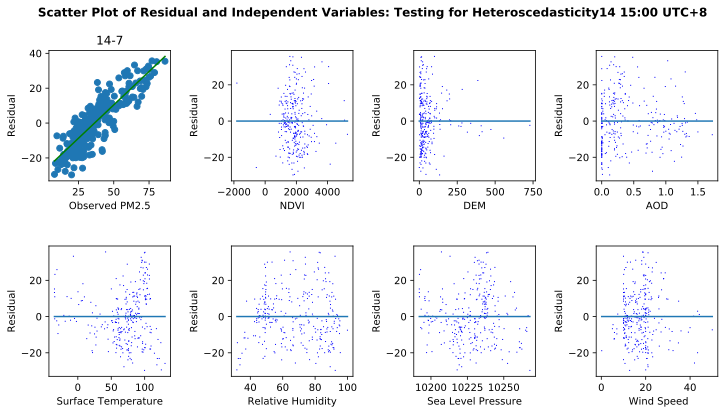

In [9]:
MLRAnalysis(14,7)

15-1
-------
MSE: 73.873810687957
R^2: 0.3395828610730761
                      Index         Value
0                  R Square  3.395829e-01
1         Adjusted R Square  3.234751e-01
2                         f  2.108197e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  1.120572e+04
5   Residual Sum of Squares  2.179277e+04
6      Total Sum of Squares  3.299850e+04

             Variable         t  Significance
0            Constant -3.621482  1.731194e-04
1                NDVI  0.538068  2.954736e-01
2                 DEM  1.379190  8.445502e-02
3                 AOD  2.957170  1.681445e-03
4     Air Temperature  7.987801  1.676437e-14
5   Relative Humidity  7.696098  1.135758e-13
6  Sea Level Pressure  3.564154  2.136888e-04
7          Wind Speed  2.757356  3.100377e-03




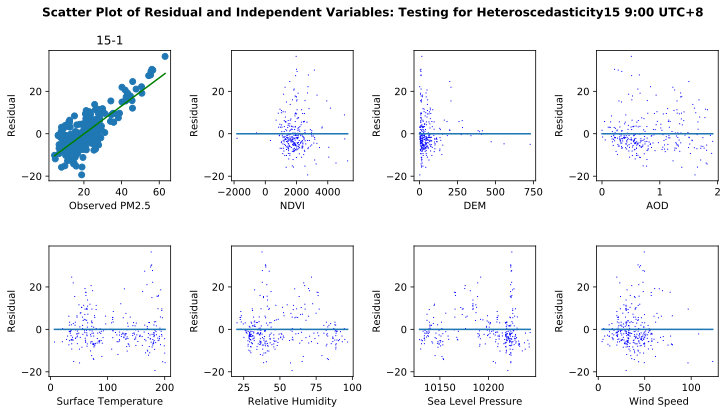

In [10]:
MLRAnalysis(15,1)

15-4
-------
MSE: 63.05661696855907
R^2: 0.3922229613329712
                      Index         Value
0                  R Square  3.922230e-01
1         Adjusted R Square  3.773991e-01
2                         f  2.645895e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  1.200443e+04
5   Residual Sum of Squares  1.860170e+04
6      Total Sum of Squares  3.060613e+04

             Variable         t  Significance
0            Constant -7.321859  1.237566e-12
1                NDVI  0.765778  2.222187e-01
2                 DEM  0.715703  2.373783e-01
3                 AOD  3.038035  1.300191e-03
4     Air Temperature  5.911519  4.801598e-09
5   Relative Humidity  7.283981  1.569300e-12
6  Sea Level Pressure  7.302510  1.397327e-12
7          Wind Speed -0.231813  4.084242e-01




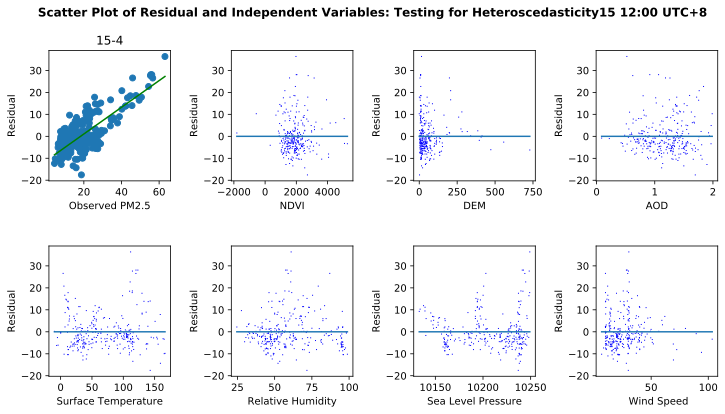

In [11]:
MLRAnalysis(15,4)

15-7
-------
MSE: 53.91414368405345
R^2: 0.4856540476276626
                      Index         Value
0                  R Square  4.856540e-01
1         Adjusted R Square  4.731090e-01
2                         f  3.871289e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  1.501746e+04
5   Residual Sum of Squares  1.590467e+04
6      Total Sum of Squares  3.092213e+04

             Variable          t  Significance
0            Constant -11.395456      0.000000
1                NDVI   0.076928      0.469367
2                 DEM  -0.092195      0.463304
3                 AOD   3.539968      0.000233
4     Air Temperature   1.504570      0.066767
5   Relative Humidity   4.720752      0.000002
6  Sea Level Pressure  11.397561      0.000000
7          Wind Speed   1.268026      0.102908




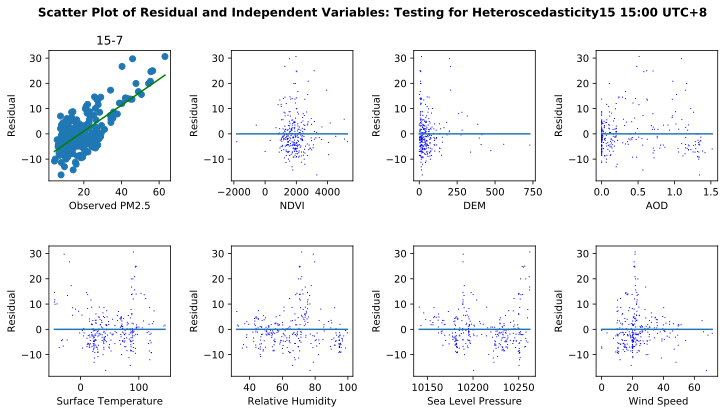

In [12]:
MLRAnalysis(15,7)

16-1
-------
MSE: 69.68924623901319
R^2: 0.3082822982043736
                      Index         Value
0                  R Square  3.082823e-01
1         Adjusted R Square  2.914111e-01
2                         f  1.827273e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  9.162363e+03
5   Residual Sum of Squares  2.055833e+04
6      Total Sum of Squares  2.972069e+04

             Variable         t  Significance
0            Constant -5.166452  2.236296e-07
1                NDVI  0.711967  2.385316e-01
2                 DEM  1.212129  1.132300e-01
3                 AOD  3.143551  9.219755e-04
4     Air Temperature  3.967002  4.599817e-05
5   Relative Humidity  2.497020  6.542325e-03
6  Sea Level Pressure  5.123494  2.757400e-07
7          Wind Speed -1.582831  5.728064e-02




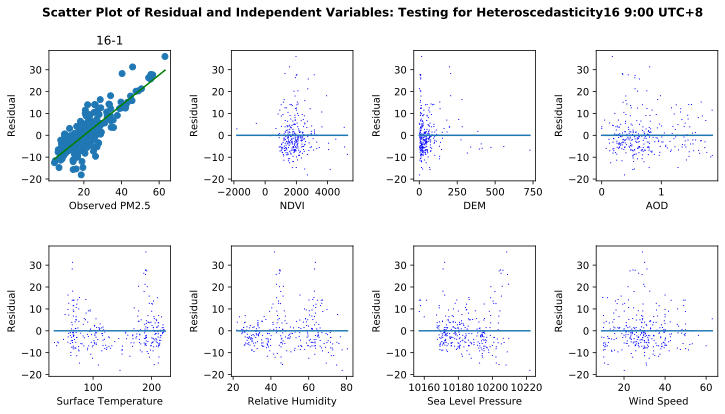

In [13]:
MLRAnalysis(16,1)

16-4
-------
MSE: 73.60895150803569
R^2: 0.2980131212279913
                      Index         Value
0                  R Square  2.980131e-01
1         Adjusted R Square  2.808915e-01
2                         f  1.740565e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  9.218474e+03
5   Residual Sum of Squares  2.171464e+04
6      Total Sum of Squares  3.093311e+04

             Variable         t  Significance
0            Constant  0.577151  2.821450e-01
1                NDVI  0.675257  2.500282e-01
2                 DEM  0.221764  4.123277e-01
3                 AOD  2.024847  2.190438e-02
4     Air Temperature  7.446592  5.629941e-13
5   Relative Humidity  7.644103  1.589839e-13
6  Sea Level Pressure -0.620771  2.676214e-01
7          Wind Speed -0.090623  4.639278e-01




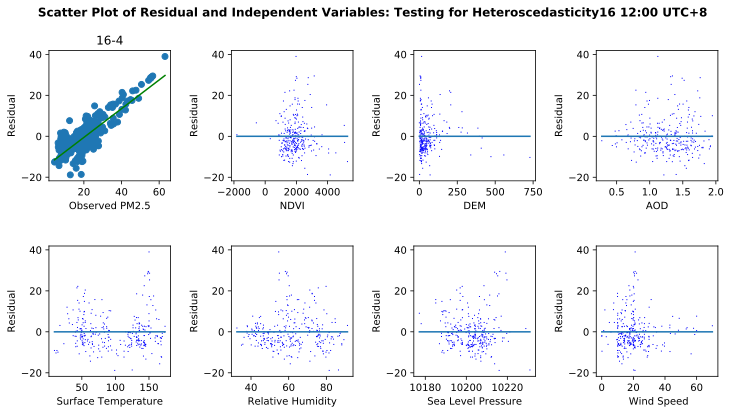

In [14]:
MLRAnalysis(16,4)

16-7
-------
MSE: 60.58356860147489
R^2: 0.40582702047668673
                      Index         Value
0                  R Square  4.058270e-01
1         Adjusted R Square  3.913350e-01
2                         f  2.800347e+01
3            f_significance  1.110223e-16
4  Explained Sum of Squares  1.220689e+04
5   Residual Sum of Squares  1.787215e+04
6      Total Sum of Squares  3.007904e+04

             Variable         t  Significance
0            Constant  3.527122  2.444699e-04
1                NDVI  0.424572  3.357333e-01
2                 DEM -2.127448  1.711766e-02
3                 AOD  5.080192  3.400996e-07
4     Air Temperature  7.352617  1.019962e-12
5   Relative Humidity  7.546305  2.980949e-13
6  Sea Level Pressure -3.564248  2.136152e-04
7          Wind Speed  0.822245  2.058100e-01




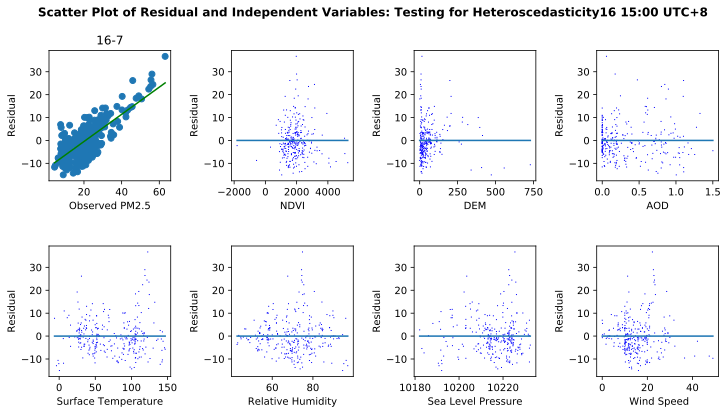

In [15]:
MLRAnalysis(16,7)

Based on the figures, we can conclude that no heteroscedasticity was found with the residual. While we found the trend where the redidual increases as PM2.5 increases.